# Example of usage 

### Install library

In [1]:
# !pip install praat-textgrids

### Load data from kaggle

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

### Define the function extracting the ground truth labels

It's important for this kind of tasks to perform short time analysis on the signal, so it needs to assign the lables (SPEECH/NONSPEECH) to very little portions of the signal. I decide to split the data into portion of 30 milliseconds.

In [5]:
import textgrids

FRAME_DURATION = 30 # 30 msec
OVERLAP_RATE = 0.0 # frames don't overlap

def readFile(path):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silence']:
        label = int(interval.text)

        dur = interval.dur
        dur_msec = dur * 1000 # sec -> msec
        num_frames = int(round(dur_msec /30)) # the audio is divided into 30 msec frames
        print(dur_msec)
        for i in range(num_frames):
            
            labeled_list.append(label)

    return labeled_list

## Load a file

In [6]:
# !pip install librosa
import librosa

root ='/Users/perrine/Desktop/Stage_2023-2024/TEXTGRID_WAV'
annotation_path = "/Users/perrine/Desktop/Stage_2023-2024/TEXTGRID_WAV/ABJ_GWA_03/ABJ_GWA_03_Cost-Of-Living-In-Abuja_MG_speech_non_speech.TextGrid"
audio_path = "/Users/perrine/Desktop/Stage_2023-2024/TEXTGRID_WAV/ABJ_GWA_03/ABJ_GWA_03_Cost-Of-Living-In-Abuja_MG.wav"

# read annotaion
label_list = readFile(annotation_path)

# read wav file
data, fs = librosa.load(audio_path)

2092.0
1085.9999999999998
712.0000000000002
678.9999999999998
828.9999999999998
1038.0000000000002
355.00000000000045
1763.9999999999993
682.9999999999998
1836.0000000000002
567.0000000000002
2478.999999999999
469.0000000000012
3897.9999999999977
637.0000000000005
948.0000000000005
100.99999999999909
2293.0000000000027
270.99999999999727
2700.0000000000027
839.9999999999999
1532.9999999999977
336.9999999999998
1325.0000000000027
339.9999999999999
1637.0000000000005
453.99999999999704
2849.0000000000036
445.99999999999795
3048.000000000002
375.0
1552.9999999999973
645.0000000000032
640.9999999999982
368.0000000000021
1971.999999999994
298.0000000000018
3512.0000000000005
396.99999999999847
600.0000000000014
399.9999999999986
3530.000000000001
594.0000000000011
383.0000000000027
271.99999999999847
1149.9999999999986
472.999999999999
5265.999999999998
330.0000000000054
1225.999999999999
411.99999999999903
1781.9999999999964
380.00000000000966
2343.999999999994
444.9999999999932
998.000000

## Plot signal

### Preparing the variable

In [9]:
# define time axis
Ns = len(data)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * 1000 * Ts  # time axis


shift = 1 - OVERLAP_RATE
frame_length = int(np.floor(FRAME_DURATION * fs / 1000)) # frame length in sample
frame_shift = round(frame_length * shift)# frame shift in sample


/Users/perrine/Desktop/Stage_2023-2024/stage_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


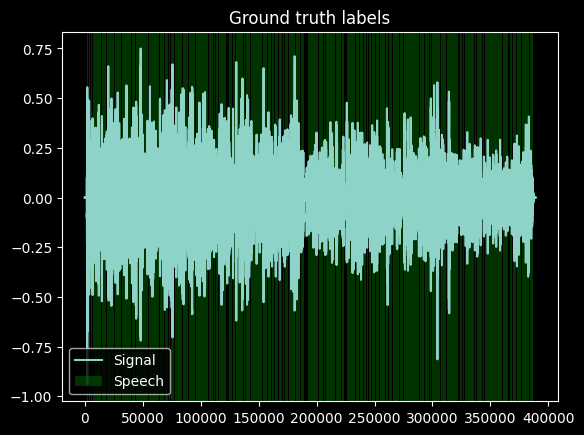

In [10]:
import matplotlib.pyplot as plt

figure = plt.Figure(figsize=(10, 7), dpi=85)
plt.plot(t, data)

for i, frame_labeled in enumerate(label_list):
    idx = i * frame_shift
    if (frame_labeled == 1):
        plt.axvspan(xmin= t[idx], xmax=t[idx + frame_length-1], ymin=-1000, ymax=1000, alpha=0.4, zorder=-100, facecolor='g', label='Speech')

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech'])
plt.show()

In [11]:
print(len(label_list))
print(len(t))
print(len(data))

12901
8574912
8574912


The green parts indicates the frames where an human speech is detected.

# Voice Activity Detection:

## Preparation:

### Libraries:

In [10]:
# !pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=2497f27fea2457e30224604eca65dc766357c0b32a4f1cbd9fdb376a91fb0fd5
  Stored in directory: /Users/perrine/Library/Caches/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


In [12]:
import os # Working with directories
import python_speech_features # For exctracting features for deep learning
from tqdm import tqdm # Progress meter
from sklearn import model_selection, preprocessing, metrics # Preparation data
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### Load all files:

Let's redefine funtion that has already been implemented above

In [13]:
# Function for reading labels from .TextGrig file:
def readLabels(path, sample_rate):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silence']:
        label = int(interval.text)

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate)) # sec -> num of samples
        
        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list

In [14]:
# Function for getting all files in directories and sub-directories with definite extension:
def getFiles(path, extension):
    list_paths = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(extension)):
                list_paths.append(os.path.join(root, file))
    return list_paths

In [37]:
def augment_data(X, y):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        # Ajoutez l'original
        augmented_X.append(X[i])
        augmented_y.append(y[i])

        # Ajoutez des versions augmentées (par exemple, bruit blanc, shift temporel, etc.)
        noise = np.random.normal(0, 0.05, X[i].shape)
        augmented_X.append(X[i] + noise)
        augmented_y.append(y[i])
        
        # Ajoutez d'autres transformations si nécessaire

    return np.array(augmented_X), np.array(augmented_y)

In [38]:
annotation_path = '/Users/perrine/Desktop/Stage_2023-2024/TEXTGRID_WAV/'
annotation_extension = '_speech_non_speech.TextGrid'
audio_extension = '_16000Hz.wav'

annotation_files = []
audio_files = []

for root, dirs, files in os.walk(annotation_path):
    for file in files:
        if file.endswith(annotation_extension):
            annotation_files.append(os.path.join(root, file))
            corresponding_audio_file = os.path.join(root, file.replace(annotation_extension, audio_extension))
            if os.path.exists(corresponding_audio_file):
                audio_files.append(corresponding_audio_file)
            else:
                print(f'Warning: Corresponding audio file for {file} not found.')

annotation_files = sorted(annotation_files)
audio_files = sorted(audio_files)

print('Number of annotation files:', len(annotation_files))
print('Number of audio files:', len(audio_files))

Number of annotation files: 80
Number of audio files: 80


## Processing files:

Algorithm based on a article "A HYBRID CNN-BILSTM VOICE ACTIVITY DETECTOR"

In preprocessing part we need extract Mel filter bank energies from signal as a features. Features are extracted every 10 ms using a 25 ms window. We will use 32 Mel log energies and the log energy of frame. And after extracting, we need form sequences of 32 × 32 spectrogram imagesas input features.

In [39]:
# Set params for model:
preemphasis_coef = 0.97 # Coefficient for pre-processing filter
frame_length = 0.025 # Window length in sec
frame_step = 0.01 # Length of step in sec
num_nfft = 512 # Point for FFT
num_features = 32 # Number of Mel filters
n_frames = 32 # Number of frames for uniting in image

In [40]:
# Extraction features for each file
dataset = list()
for i in tqdm(range(len(audio_files))):
    sig, sample_rate = librosa.load(audio_files[i])
    markers = readLabels(path=annotation_files[i], sample_rate=sample_rate)
    
    # Calculate the frame length in samples
    frame_length_samples = int(frame_length * sample_rate)
    num_nfft = max(512, int(2**np.ceil(np.log2(frame_length_samples))))  # Adjust NFFT to be at least as large as frame length in samples

    # Print the adjusted NFFT value
    print(f"Processing file {i+1}/{len(audio_files)} - Adjusted NFFT size: {num_nfft}")

    # Extract logfbank features
    features_logfbank = python_speech_features.base.logfbank(
        signal=sig,
        samplerate=sample_rate,
        winlen=frame_length,
        winstep=frame_step,
        nfilt=num_features,
        nfft=num_nfft,
        lowfreq=0,
        highfreq=None,
        preemph=preemphasis_coef
    )
    
    # Reshape labels for each group of features
    frame_len = int(frame_length * sample_rate)
    frame_step_len = int(frame_step * sample_rate)
    markers_of_frames = python_speech_features.sigproc.framesig(
        sig=markers,
        frame_len=frame_len,
        frame_step=frame_step_len,
        winfunc=np.ones
    )
    
    # Calculate label for every frame
    marker_per_frame = np.array([
        1 if np.sum(markers_of_frames[j]) > markers_of_frames.shape[1] / 2 else 0
        for j in range(markers_of_frames.shape[0])
    ])
    
    # Generate spectrogram images and corresponding labels
    for j in range(int(np.floor(features_logfbank.shape[0] / n_frames))):
        spectrogram_image = features_logfbank[j * n_frames:(j + 1) * n_frames]
        label_spectrogram_image = 1 if np.sum(marker_per_frame[j * n_frames:(j + 1) * n_frames]) > n_frames / 2 else 0
        dataset.append((label_spectrogram_image, spectrogram_image))

print(f"Total number of spectrogram images: {len(dataset)}")

  0%|          | 0/80 [00:00<?, ?it/s]

Processing file 1/80 - Adjusted NFFT size: 1024


  1%|▏         | 1/80 [00:01<02:14,  1.71s/it]

Processing file 2/80 - Adjusted NFFT size: 1024


  2%|▎         | 2/80 [00:03<01:55,  1.48s/it]

Processing file 3/80 - Adjusted NFFT size: 1024


  4%|▍         | 3/80 [00:05<02:19,  1.81s/it]

Processing file 4/80 - Adjusted NFFT size: 1024


  5%|▌         | 4/80 [00:05<01:46,  1.40s/it]

Processing file 5/80 - Adjusted NFFT size: 1024


  6%|▋         | 5/80 [00:07<01:46,  1.43s/it]

Processing file 6/80 - Adjusted NFFT size: 1024


  8%|▊         | 6/80 [00:08<01:43,  1.40s/it]

Processing file 7/80 - Adjusted NFFT size: 1024


  9%|▉         | 7/80 [00:10<01:41,  1.39s/it]

Processing file 8/80 - Adjusted NFFT size: 1024


 10%|█         | 8/80 [00:11<01:37,  1.35s/it]

Processing file 9/80 - Adjusted NFFT size: 1024


 11%|█▏        | 9/80 [00:12<01:35,  1.34s/it]

Processing file 10/80 - Adjusted NFFT size: 1024


 12%|█▎        | 10/80 [00:13<01:29,  1.28s/it]

Processing file 11/80 - Adjusted NFFT size: 1024


 14%|█▍        | 11/80 [00:15<01:25,  1.24s/it]

Processing file 12/80 - Adjusted NFFT size: 1024


 15%|█▌        | 12/80 [00:16<01:26,  1.27s/it]

Processing file 13/80 - Adjusted NFFT size: 1024


 16%|█▋        | 13/80 [00:17<01:20,  1.20s/it]

Processing file 14/80 - Adjusted NFFT size: 1024


 18%|█▊        | 14/80 [00:18<01:10,  1.07s/it]

Processing file 15/80 - Adjusted NFFT size: 1024


 19%|█▉        | 15/80 [00:18<01:02,  1.03it/s]

Processing file 16/80 - Adjusted NFFT size: 1024


 20%|██        | 16/80 [00:20<01:10,  1.10s/it]

Processing file 17/80 - Adjusted NFFT size: 1024


 21%|██▏       | 17/80 [00:21<01:07,  1.07s/it]

Processing file 18/80 - Adjusted NFFT size: 1024


 22%|██▎       | 18/80 [00:22<01:03,  1.03s/it]

Processing file 19/80 - Adjusted NFFT size: 1024


 24%|██▍       | 19/80 [00:23<01:00,  1.00it/s]

Processing file 20/80 - Adjusted NFFT size: 1024


 25%|██▌       | 20/80 [00:24<00:59,  1.00it/s]

Processing file 21/80 - Adjusted NFFT size: 1024


 26%|██▋       | 21/80 [00:25<01:03,  1.07s/it]

Processing file 22/80 - Adjusted NFFT size: 1024


 28%|██▊       | 22/80 [00:26<01:07,  1.16s/it]

Processing file 23/80 - Adjusted NFFT size: 1024


 29%|██▉       | 23/80 [00:28<01:11,  1.26s/it]

Processing file 24/80 - Adjusted NFFT size: 1024


 30%|███       | 24/80 [00:30<01:23,  1.49s/it]

Processing file 25/80 - Adjusted NFFT size: 1024


 31%|███▏      | 25/80 [00:32<01:32,  1.69s/it]

Processing file 26/80 - Adjusted NFFT size: 1024


 32%|███▎      | 26/80 [00:34<01:37,  1.80s/it]

Processing file 27/80 - Adjusted NFFT size: 1024


 34%|███▍      | 27/80 [00:38<02:04,  2.34s/it]

Processing file 28/80 - Adjusted NFFT size: 1024


 35%|███▌      | 28/80 [00:39<01:44,  2.01s/it]

Processing file 29/80 - Adjusted NFFT size: 1024


 36%|███▋      | 29/80 [00:40<01:30,  1.78s/it]

Processing file 30/80 - Adjusted NFFT size: 1024


 38%|███▊      | 30/80 [00:41<01:19,  1.59s/it]

Processing file 31/80 - Adjusted NFFT size: 1024


 39%|███▉      | 31/80 [00:43<01:14,  1.51s/it]

Processing file 32/80 - Adjusted NFFT size: 1024


 40%|████      | 32/80 [00:45<01:19,  1.66s/it]

Processing file 33/80 - Adjusted NFFT size: 1024


 41%|████▏     | 33/80 [00:46<01:14,  1.58s/it]

Processing file 34/80 - Adjusted NFFT size: 1024


 42%|████▎     | 34/80 [00:48<01:24,  1.84s/it]

Processing file 35/80 - Adjusted NFFT size: 1024


 44%|████▍     | 35/80 [00:50<01:13,  1.64s/it]

Processing file 36/80 - Adjusted NFFT size: 1024


 45%|████▌     | 36/80 [00:50<00:58,  1.34s/it]

Processing file 37/80 - Adjusted NFFT size: 1024


 46%|████▋     | 37/80 [00:51<00:53,  1.24s/it]

Processing file 38/80 - Adjusted NFFT size: 1024


 48%|████▊     | 38/80 [00:52<00:51,  1.22s/it]

Processing file 39/80 - Adjusted NFFT size: 1024


 49%|████▉     | 39/80 [00:54<00:52,  1.28s/it]

Processing file 40/80 - Adjusted NFFT size: 1024


 50%|█████     | 40/80 [00:55<00:51,  1.30s/it]

Processing file 41/80 - Adjusted NFFT size: 1024


 51%|█████▏    | 41/80 [00:57<00:53,  1.36s/it]

Processing file 42/80 - Adjusted NFFT size: 1024


 52%|█████▎    | 42/80 [00:58<00:51,  1.35s/it]

Processing file 43/80 - Adjusted NFFT size: 1024


 54%|█████▍    | 43/80 [00:59<00:48,  1.31s/it]

Processing file 44/80 - Adjusted NFFT size: 1024


 55%|█████▌    | 44/80 [01:01<00:49,  1.37s/it]

Processing file 45/80 - Adjusted NFFT size: 1024


 56%|█████▋    | 45/80 [01:02<00:44,  1.28s/it]

Processing file 46/80 - Adjusted NFFT size: 1024


 57%|█████▊    | 46/80 [01:03<00:44,  1.31s/it]

Processing file 47/80 - Adjusted NFFT size: 1024


 59%|█████▉    | 47/80 [01:05<00:46,  1.42s/it]

Processing file 48/80 - Adjusted NFFT size: 1024


 60%|██████    | 48/80 [01:07<00:50,  1.58s/it]

Processing file 49/80 - Adjusted NFFT size: 1024


 61%|██████▏   | 49/80 [01:08<00:45,  1.46s/it]

Processing file 50/80 - Adjusted NFFT size: 1024


 62%|██████▎   | 50/80 [01:09<00:42,  1.42s/it]

Processing file 51/80 - Adjusted NFFT size: 1024


 64%|██████▍   | 51/80 [01:12<00:47,  1.65s/it]

Processing file 52/80 - Adjusted NFFT size: 1024


 65%|██████▌   | 52/80 [01:13<00:46,  1.67s/it]

Processing file 53/80 - Adjusted NFFT size: 1024


 66%|██████▋   | 53/80 [01:15<00:42,  1.57s/it]

Processing file 54/80 - Adjusted NFFT size: 1024


 68%|██████▊   | 54/80 [01:15<00:34,  1.33s/it]

Processing file 55/80 - Adjusted NFFT size: 1024


 69%|██████▉   | 55/80 [01:17<00:31,  1.28s/it]

Processing file 56/80 - Adjusted NFFT size: 1024


 70%|███████   | 56/80 [01:18<00:29,  1.25s/it]

Processing file 57/80 - Adjusted NFFT size: 1024


 71%|███████▏  | 57/80 [01:19<00:29,  1.28s/it]

Processing file 58/80 - Adjusted NFFT size: 1024


 72%|███████▎  | 58/80 [01:20<00:25,  1.15s/it]

Processing file 59/80 - Adjusted NFFT size: 1024


 74%|███████▍  | 59/80 [01:21<00:21,  1.02s/it]

Processing file 60/80 - Adjusted NFFT size: 1024


 75%|███████▌  | 60/80 [01:22<00:21,  1.05s/it]

Processing file 61/80 - Adjusted NFFT size: 1024


 76%|███████▋  | 61/80 [01:24<00:24,  1.26s/it]

Processing file 62/80 - Adjusted NFFT size: 1024


 78%|███████▊  | 62/80 [01:25<00:21,  1.20s/it]

Processing file 63/80 - Adjusted NFFT size: 1024


 79%|███████▉  | 63/80 [01:26<00:21,  1.29s/it]

Processing file 64/80 - Adjusted NFFT size: 1024


 80%|████████  | 64/80 [01:28<00:22,  1.42s/it]

Processing file 65/80 - Adjusted NFFT size: 1024


 81%|████████▏ | 65/80 [01:29<00:21,  1.44s/it]

Processing file 66/80 - Adjusted NFFT size: 1024


 82%|████████▎ | 66/80 [01:30<00:17,  1.21s/it]

Processing file 67/80 - Adjusted NFFT size: 1024


 84%|████████▍ | 67/80 [01:32<00:17,  1.37s/it]

Processing file 68/80 - Adjusted NFFT size: 1024


 85%|████████▌ | 68/80 [01:33<00:16,  1.42s/it]

Processing file 69/80 - Adjusted NFFT size: 1024


 86%|████████▋ | 69/80 [01:34<00:13,  1.25s/it]

Processing file 70/80 - Adjusted NFFT size: 1024


 88%|████████▊ | 70/80 [01:36<00:13,  1.31s/it]

Processing file 71/80 - Adjusted NFFT size: 1024


 89%|████████▉ | 71/80 [01:37<00:12,  1.39s/it]

Processing file 72/80 - Adjusted NFFT size: 1024


 90%|█████████ | 72/80 [01:38<00:09,  1.19s/it]

Processing file 73/80 - Adjusted NFFT size: 1024


 91%|█████████▏| 73/80 [01:40<00:10,  1.44s/it]

Processing file 74/80 - Adjusted NFFT size: 1024


 92%|█████████▎| 74/80 [01:41<00:07,  1.30s/it]

Processing file 75/80 - Adjusted NFFT size: 1024


 94%|█████████▍| 75/80 [01:43<00:07,  1.49s/it]

Processing file 76/80 - Adjusted NFFT size: 1024


 95%|█████████▌| 76/80 [01:45<00:06,  1.59s/it]

Processing file 77/80 - Adjusted NFFT size: 1024


 96%|█████████▋| 77/80 [01:46<00:04,  1.60s/it]

Processing file 78/80 - Adjusted NFFT size: 1024


 98%|█████████▊| 78/80 [01:48<00:03,  1.56s/it]

Processing file 79/80 - Adjusted NFFT size: 1024


 99%|█████████▉| 79/80 [01:50<00:01,  1.82s/it]

Processing file 80/80 - Adjusted NFFT size: 1024


100%|██████████| 80/80 [01:52<00:00,  1.40s/it]

Total number of spectrogram images: 87324


In [18]:
markers_of_frames.shape

(38471, 551)

## Build and train the model:

We will use model shown in the picture below

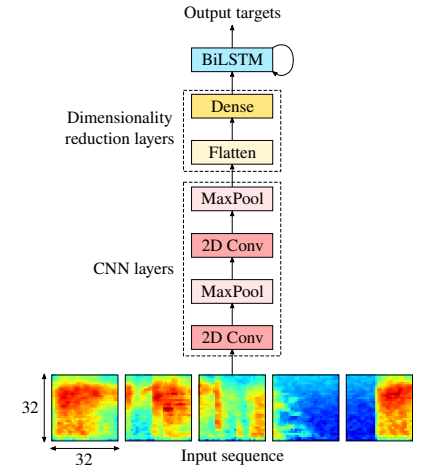

### Preparation data:

In [41]:
# Split dataset on train and test:
X = list()
y = list()
for i in range(len(dataset)):
    X.append(dataset[i][1])
    y.append(dataset[i][0])
    
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Reshaping for scaling:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
    
# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# And reshape back:
X_train = X_train.reshape(X_train.shape[0], n_frames, n_frames)
X_test = X_test.reshape(X_test.shape[0], n_frames, n_frames)

(58507, 32, 32) (28817, 32, 32) (58507,) (28817,)


In [42]:
# # Encoding label:
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)


# Encoding label
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

# Augmenter les données
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)


In [43]:
# Reshape data for convolution layer:
stride = int(15)

X_train_reshaped = X_train_augmented[:len(X_train_augmented) // stride * stride]
X_test_reshaped = X_test[:len(X_test) // stride * stride]

y_train_reshaped = y_train_augmented[:len(y_train_augmented) // stride * stride]
y_test_reshaped = y_test[:len(y_test) // stride * stride]

X_train_reshaped = X_train_reshaped.reshape((len(X_train_reshaped) // stride, stride, n_frames, n_frames, 1))
X_test_reshaped = X_test_reshaped.reshape((len(X_test_reshaped) // stride, stride, n_frames, n_frames, 1))

y_train_reshaped = y_train_reshaped.reshape((len(y_train_reshaped) // stride, stride, y_train.shape[1]))
y_test_reshaped = y_test_reshaped.reshape((len(y_test_reshaped) // stride, stride, y_test.shape[1]))


In [44]:
X_train_reshaped.shape

(7800, 15, 32, 32, 1)

### Build model:

In [49]:
input_shape = (stride, n_frames, n_frames, 1)
output_shape = y_train.shape[1]

from tensorflow.keras.optimizers import Adam

# Créer le modèle avec régularisation et arrêt précoce
inputs = Input(shape=input_shape)
x = layers.TimeDistributed(layers.Conv2D(64, (5, 5), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(inputs)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.TimeDistributed(layers.Dense(64, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.TimeDistributed(layers.Dense(output_shape, activation='softmax'))(x)


model = models.Model(inputs, outputs)
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


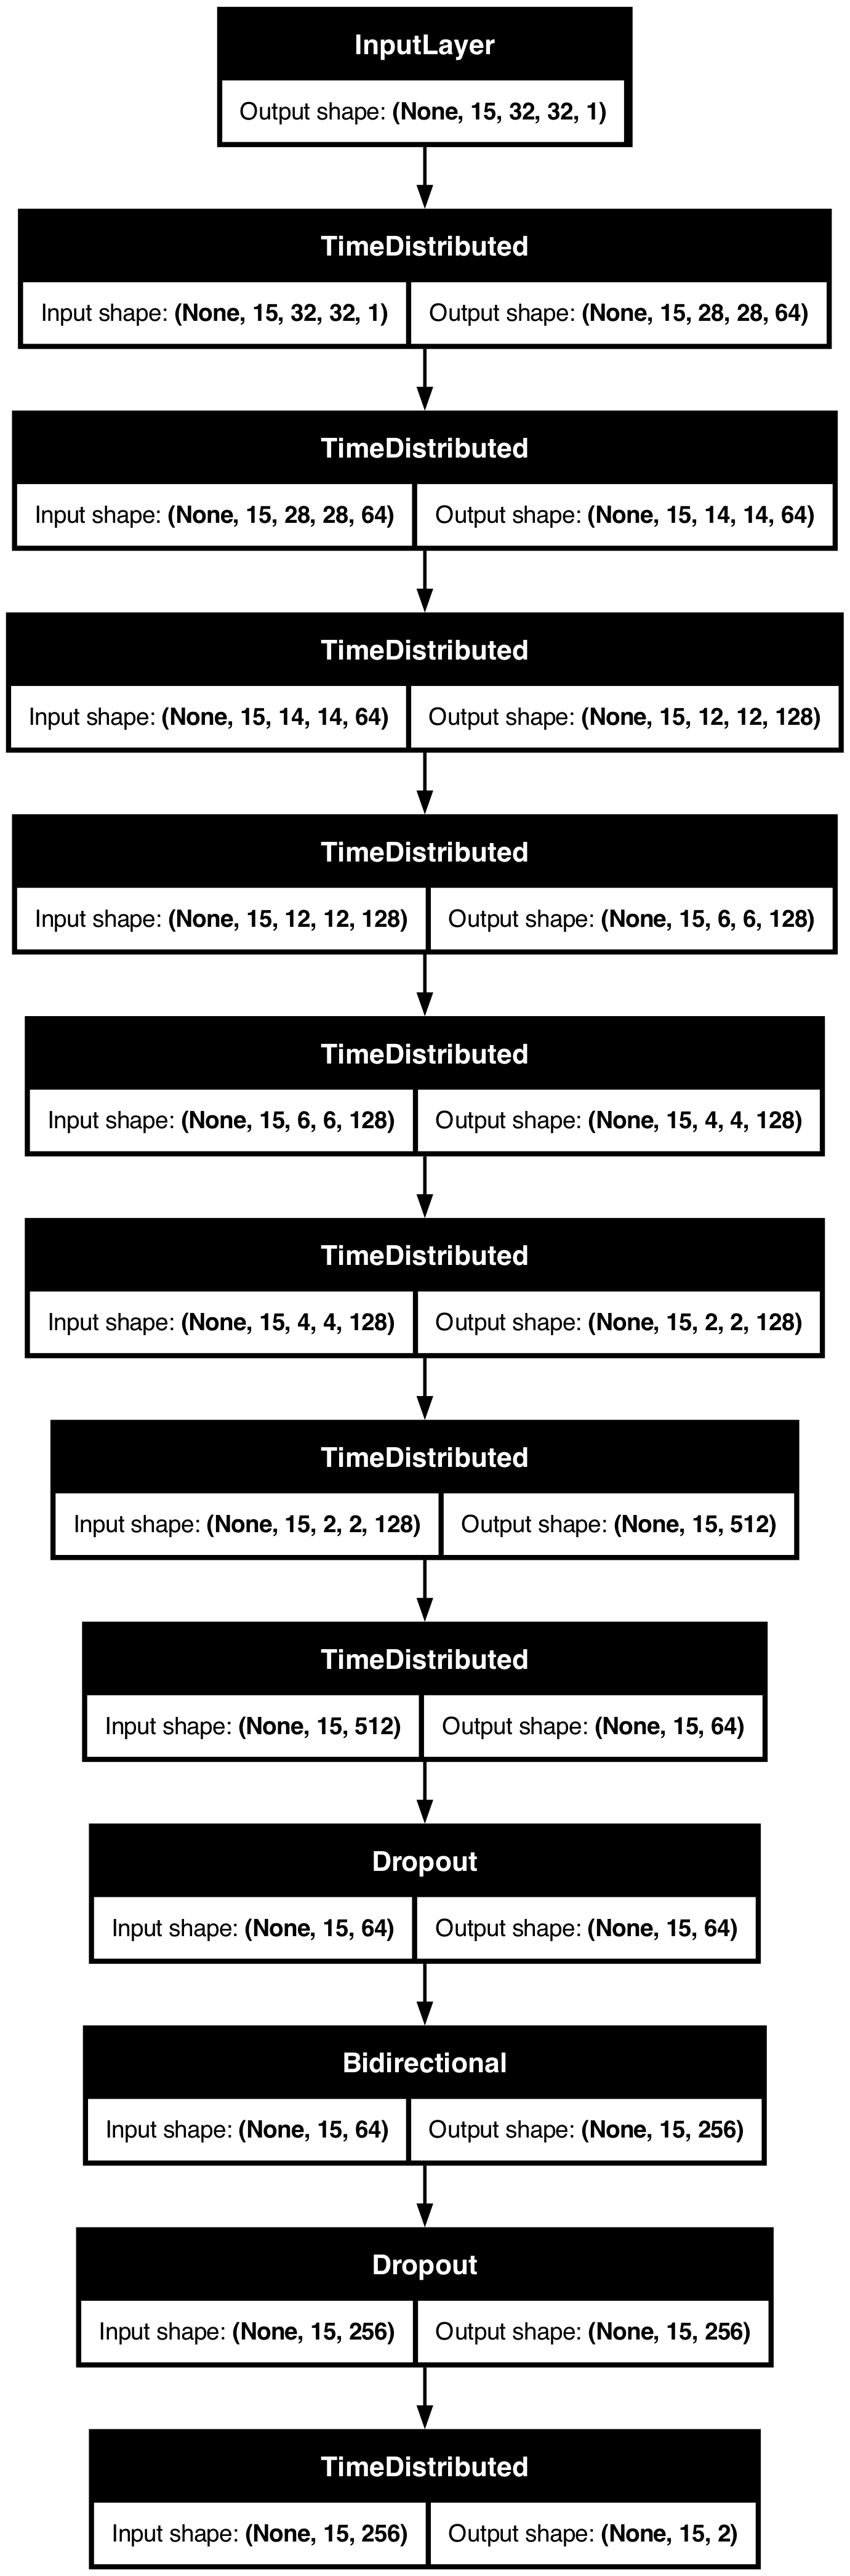

In [47]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, 'model.png', show_shapes=True)

In [50]:
epochs = 25
batch_size = 32
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]


history = model.fit(
    X_train_reshaped, y_train_reshaped,
    validation_data=(X_test_reshaped, y_test_reshaped),
    epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 170s 667ms/step - accuracy: 0.7599 - loss: 0.9578 - val_accuracy: 0.7701 - val_loss: 0.6416
Epoch 2/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 164s 672ms/step - accuracy: 0.7705 - loss: 0.6124 - val_accuracy: 0.7713 - val_loss: 0.5540
Epoch 3/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 163s 669ms/step - accuracy: 0.7681 - loss: 0.5504 - val_accuracy: 0.7707 - val_loss: 0.5369
Epoch 4/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 163s 669ms/step - accuracy: 0.7718 - loss: 0.5329 - val_accuracy: 0.7698 - val_loss: 0.5299
Epoch 5/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 163s 670ms/step - accuracy: 0.7727 - loss: 0.5253 - val_accuracy: 0.7700 - val_loss: 0.5299
Epoch 6/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 163s 667ms/step - accuracy: 0.7712 - loss: 0.5287 - val_accuracy: 0.7677 - val_loss: 0.5283
Epoch 7/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 162s 664ms/step - accuracy: 0.7685 - loss: 0.5290 - val_accuracy: 0.7708 - val_loss: 0.5262
Epoch 8/25
244/244 ━━━━━━━━━━━━━━━━━━━━ 162s 665ms/step - accuracy: 0.7708 -

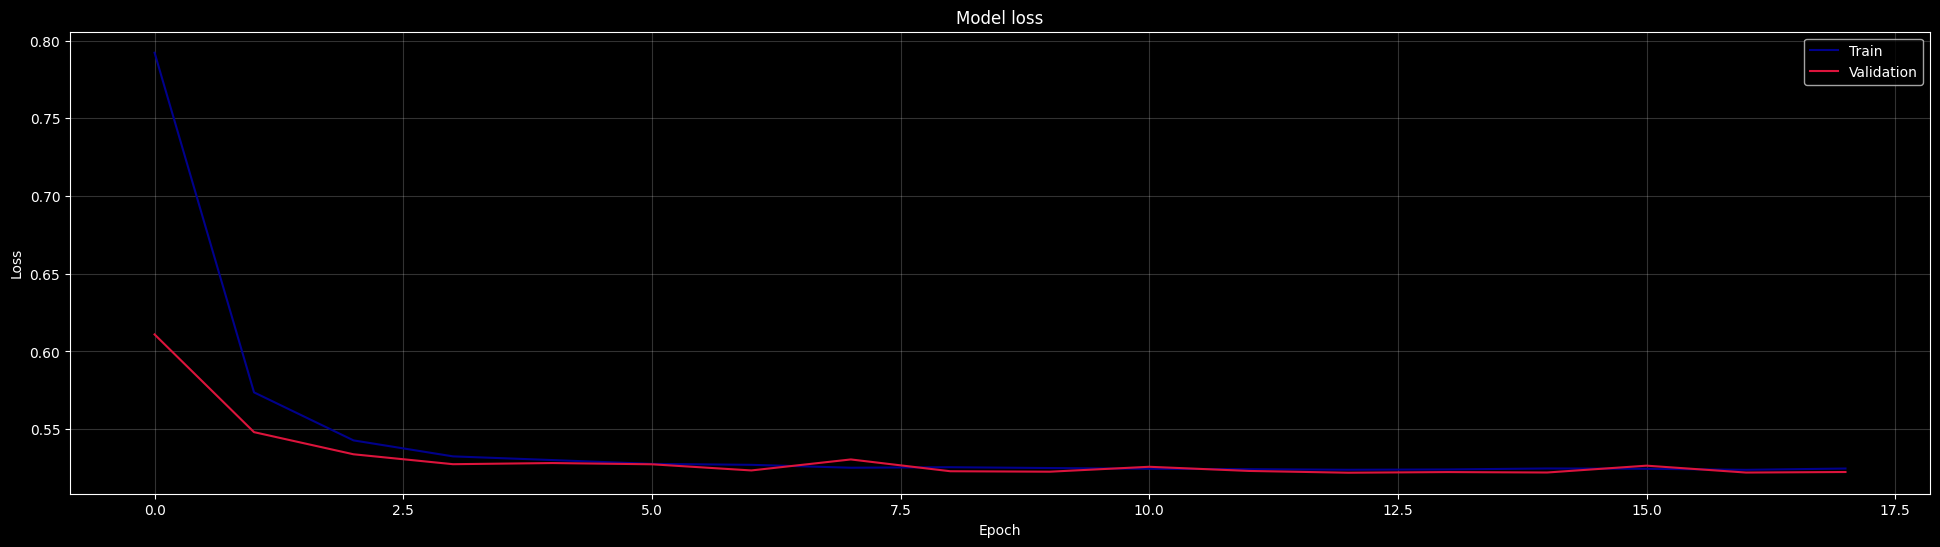

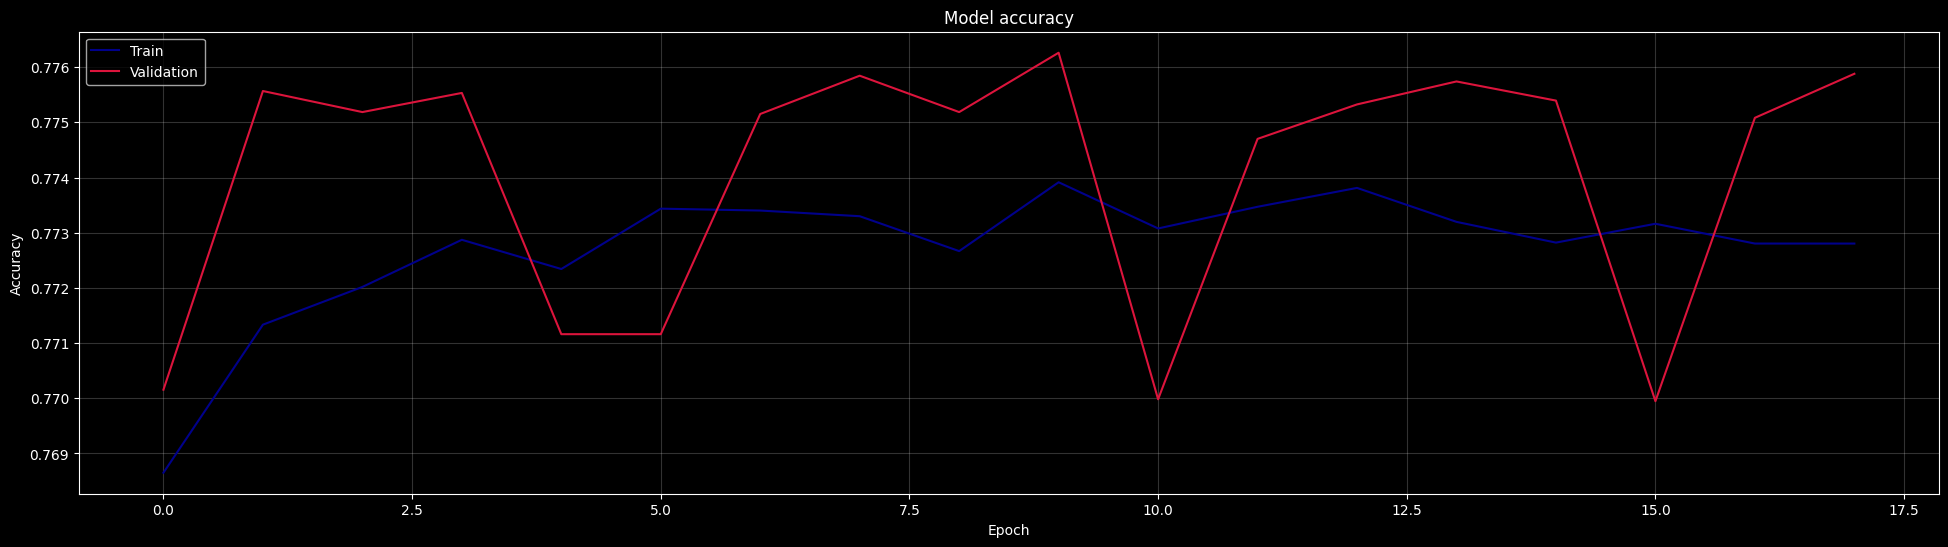

In [27]:
def plot_loss(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()
    

def plot_accuracy(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['accuracy'], c ="darkblue")
    plt.plot(history.history['val_accuracy'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha = 0.2)
    plt.show() 

    
plot_loss(history)
plot_accuracy(history)

## Validation model:

Let's will get prediction on choosen audio file and will compare with truth labels.

### Preprocessing input data (extraction features):

In [28]:
annotation_file = "/Users/perrine/Desktop/Stage_2023-2024/TEXTGRID_WAV/ABJ_GWA_03/ABJ_GWA_03_Cost-Of-Living-In-Abuja_MG_speech_non_speech.TextGrid"
audio_file = "/Users/perrine/Desktop/Stage_2023-2024/TEXTGRID_WAV/ABJ_GWA_03/ABJ_GWA_03_Cost-Of-Living-In-Abuja_MG.wav"

dataset_valid = list()

# Load samples:
input_signal, fs = librosa.load(audio_file)

# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract logfbank features:
features_logfbank_valid = python_speech_features.base.logfbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step, nfilt=num_features, 
                                                               nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef)

# Reshape labels for each group of features:
marker_per_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, 
                                                                 winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(marker_per_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(marker_per_frames_truth[j], axis=0) > marker_per_frames_truth.shape[0] / 2 else 0 
                                   for j in range(marker_per_frames_truth.shape[0])])

spectrogram_image_valid = np.zeros((n_frames, n_frames))
for j in range(int(np.floor(features_logfbank_valid.shape[0] / n_frames))):
    spectrogram_image_valid = features_logfbank_valid[j * n_frames:(j + 1) * n_frames]
    label_spectrogram_image_valid = 1 if np.sum(marker_per_frame_truth[j * n_frames:(j + 1) * n_frames]) > n_frames / 2 else 0
    dataset_valid.append((label_spectrogram_image_valid, spectrogram_image_valid))

In [29]:
if stride - len(dataset_valid) > 0:
    for i in range(stride - len(dataset_valid)):
        dataset_valid.append((0, np.zeros((n_frames, n_frames))))

In [30]:
# Split dataset on train and test:
X_valid = list()
y_valid = list()
for i in range(len(dataset_valid)):
    X_valid.append(dataset_valid[i][1])
    y_valid.append(dataset_valid[i][0])
    
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Reshaping for scaling:
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
    
# Scale data:
X_valid = scaler.transform(X_valid)

# And reshape back:
X_valid = X_valid.reshape(X_valid.shape[0], n_frames, n_frames)

In [31]:
# Encoding label:
y_truth = y_valid
y_valid = pd.get_dummies(y_valid)
y_valid = np.array(y_valid)

In [32]:
# Reshape data for convolution layer:
X_valid_reshaped = X_valid[:int(np.floor(X_valid.shape[0] / stride) * stride)]
y_valid_reshaped = y_valid[:int(np.floor(X_valid.shape[0] / stride) * stride)]

X_valid_reshaped = X_valid_reshaped.reshape((int(X_valid_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))
y_valid_reshaped = y_valid_reshaped.reshape((int(y_valid_reshaped.shape[0] / stride), stride, y_valid[-1].shape[0]))

In [33]:
prediction = model.predict(X_valid_reshaped)

predicted_label = np.zeros(prediction.shape[1])
predicted_proba = np.zeros(prediction.shape[1])
ind = 0
for i in range(prediction.shape[1]):
    if prediction[0][i][0] >= prediction[0][i][1]:
        predicted_label[ind] = 0
        predicted_proba[ind] = prediction[0][i][0]
    else:
        predicted_label[ind] = 1
        predicted_proba[ind] = prediction[0][i][1]
    ind = ind + 1
        
predicted_label

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 635ms/step


array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [34]:
print(predicted_label, y_truth)

[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0 0 0 ... 0 0 0]


In [35]:
predicted_label_widely = np.zeros(predicted_label.shape[0] * n_frames)
ind_start = 0
ind_stop = n_frames
shift_step = n_frames
for i in range(predicted_label.shape[0]):
    predicted_label_widely[ind_start:ind_stop] = predicted_label[i]
    ind_start = ind_start + shift_step
    ind_stop = ind_stop + shift_step

label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label_widely.shape[0]):
    label_timeseries[begin:end] = predicted_label_widely[i]
    begin = begin + shift_step
    end = end + shift_step

/Users/perrine/Desktop/Stage_2023-2024/stage_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


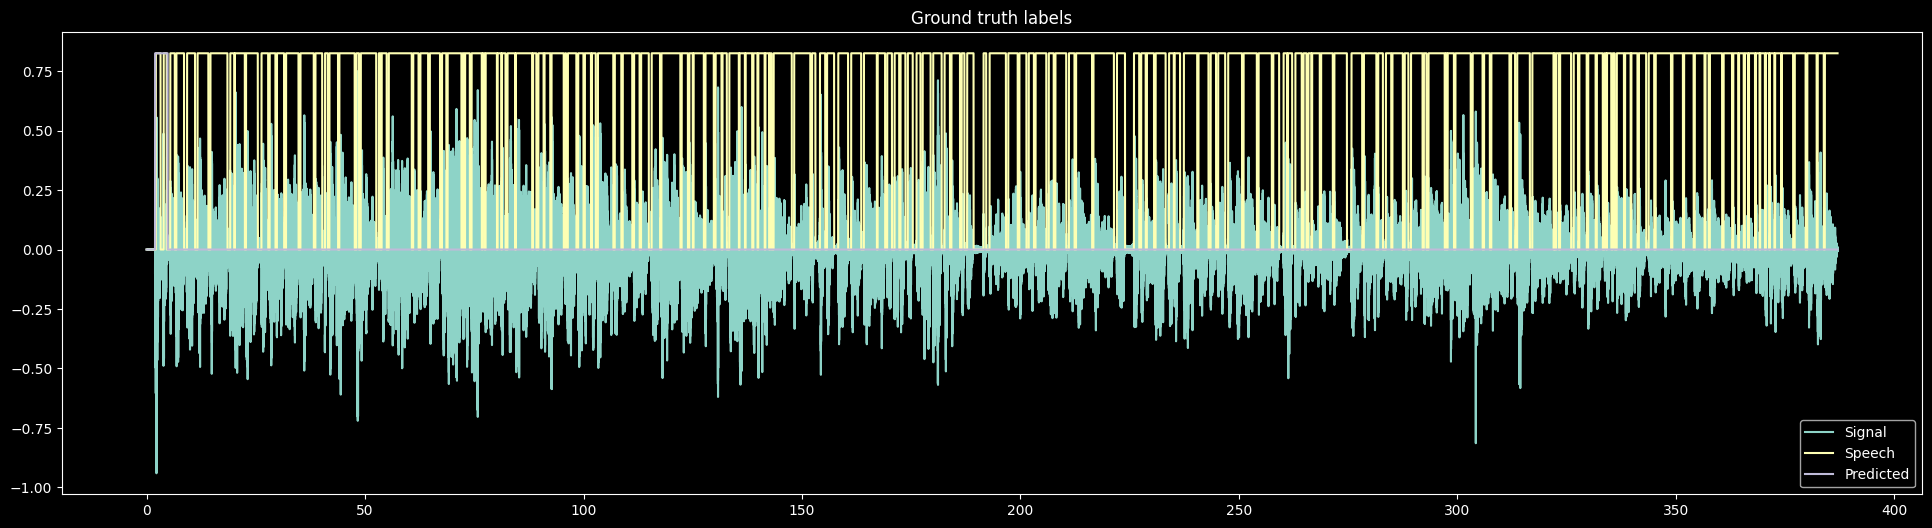

In [36]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()